In [8]:
import os
import numpy as np
import tensorflow as tf
import segmentation_models as sm
import cv2
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import random

# Khởi tạo môi trường
sm.set_framework('tf.keras')
sm.framework()

IMG_SIZE = 256
BATCH_SIZE = 8
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Đường dẫn ảnh
train_img_dir = r'C:\Users\Admin\Documents\Python Project\DPL Crack detection\UDTIRI-Crack Detection\train\image'
train_mask_dir = r'C:\Users\Admin\Documents\Python Project\DPL Crack detection\UDTIRI-Crack Detection\train\label'
val_img_dir = r'C:\Users\Admin\Documents\Python Project\DPL Crack detection\UDTIRI-Crack Detection\val\image'
val_mask_dir = r'C:\Users\Admin\Documents\Python Project\DPL Crack detection\UDTIRI-Crack Detection\val\label'

train_img_paths = sorted([os.path.join(train_img_dir, f) for f in os.listdir(train_img_dir)])
train_mask_paths = sorted([os.path.join(train_mask_dir, f) for f in os.listdir(train_mask_dir)])
val_img_paths = sorted([os.path.join(val_img_dir, f) for f in os.listdir(val_img_dir)])
val_mask_paths = sorted([os.path.join(val_mask_dir, f) for f in os.listdir(val_mask_dir)])


class DataGenerator(Sequence):
    def __init__(self, image_filenames, mask_filenames, batch_size, shuffle=True, augment=False):
        self.image_filenames = image_filenames
        self.mask_filenames = mask_filenames
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.image_filenames) / self.batch_size))

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_filenames))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        idxs = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X = np.zeros((self.batch_size, IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)
        y = np.zeros((self.batch_size, IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)
        
        for i, idx in enumerate(idxs):
            img = cv2.imread(self.image_filenames[idx])
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img / 255.0

            mask = cv2.imread(self.mask_filenames[idx], cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
            mask = mask / 255.0

            # Augmentation nếu có
            if self.augment:
                if random.random() < 0.5:
                    img = cv2.flip(img, 1)
                    mask = cv2.flip(mask, 1)
                if random.random() < 0.5:
                    img = cv2.flip(img, 0)
                    mask = cv2.flip(mask, 0)
                if random.random() < 0.5:
                    angle = random.choice([90, 180, 270])
                    img = self.rotate_image(img, angle)
                    mask = self.rotate_image(mask, angle)

            # Đảm bảo mask có shape (256, 256, 1)
            if mask.ndim == 2:
                mask = np.expand_dims(mask, axis=-1)

            X[i] = img
            y[i] = mask
        return X, y

    def rotate_image(self, image, angle):
        if angle == 90:
            return cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
        elif angle == 180:
            return cv2.rotate(image, cv2.ROTATE_180)
        elif angle == 270:
            return cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
        else:
            return image

# Tạo generator
train_gen = DataGenerator(train_img_paths, train_mask_paths, BATCH_SIZE, augment=True)
val_gen = DataGenerator(val_img_paths, val_mask_paths, BATCH_SIZE, shuffle=False)

# Tạo model
model = sm.Unet(
    backbone_name='efficientnetb0',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    classes=1,
    activation='sigmoid'
)

# === THÊM ADAMW (weight decay) ===
try:
    import tensorflow_addons as tfa
    optimizer = tfa.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-4)
except ImportError:
    print("tensorflow_addons chưa được cài, dùng Adam thường")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Compile
model.compile(
    optimizer=optimizer,
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score]
)

# Callback
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
]

# Train
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=200,
    callbacks=callbacks,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen)
)


Epoch 1/200
187/187 [==============================] - 37s 163ms/step - loss: 1.6247 - iou_score: 0.0461 - val_loss: 1.3826 - val_iou_score: 0.0254
Epoch 2/200
187/187 [==============================] - 29s 157ms/step - loss: 1.2454 - iou_score: 0.0729 - val_loss: 1.2016 - val_iou_score: 0.0373
Epoch 3/200
187/187 [==============================] - 30s 158ms/step - loss: 1.0822 - iou_score: 0.1159 - val_loss: 1.0626 - val_iou_score: 0.0828
Epoch 4/200
187/187 [==============================] - 29s 157ms/step - loss: 0.9375 - iou_score: 0.1862 - val_loss: 0.9503 - val_iou_score: 0.1426
Epoch 5/200
187/187 [==============================] - 30s 158ms/step - loss: 0.8161 - iou_score: 0.2703 - val_loss: 0.8774 - val_iou_score: 0.1931
Epoch 6/200
187/187 [==============================] - 30s 158ms/step - loss: 0.7166 - iou_score: 0.3524 - val_loss: 0.8570 - val_iou_score: 0.2120
Epoch 7/200
187/187 [==============================] - 30s 161ms/step - loss: 0.6404 - iou_score: 0.4202 - val_l

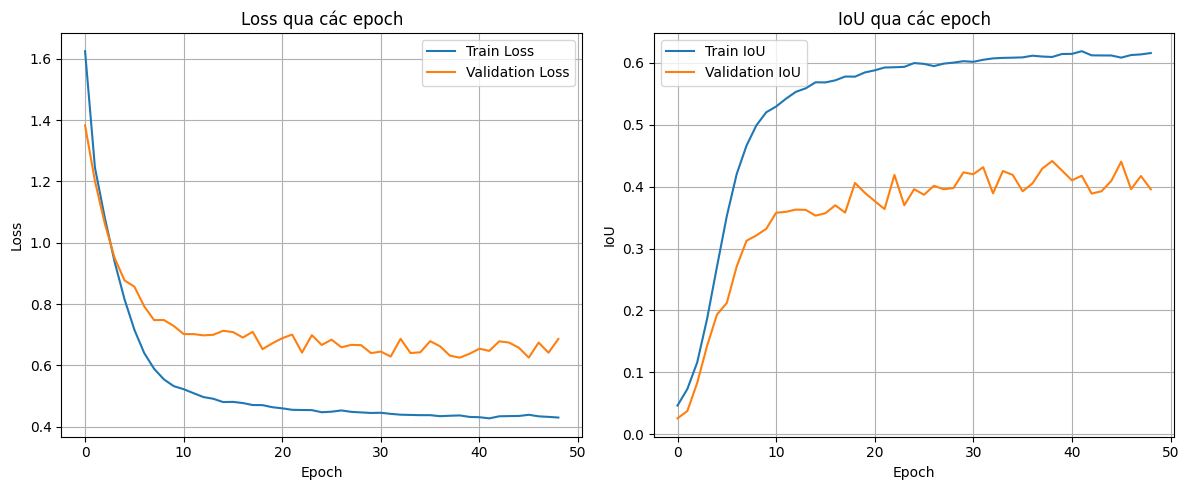

In [9]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
iou = history.history['iou_score']
val_iou = history.history['val_iou_score']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss qua các epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(iou, label='Train IoU')
plt.plot(val_iou, label='Validation IoU')
plt.title('IoU qua các epoch')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [10]:
model.save('unet_efficientnetb0_crack_segmentation.h5')
print("Model đã được lưu vào file unet_efficientnetb0_crack_segmentation.h5")


Model đã được lưu vào file unet_efficientnetb0_crack_segmentation.h5


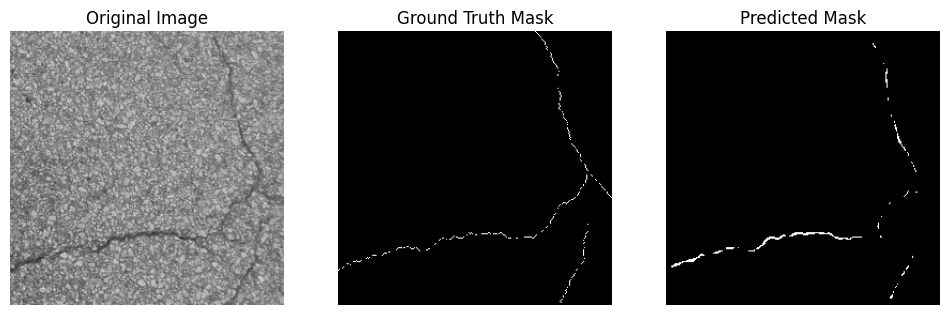

In [11]:
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np

idx = random.randint(0, len(val_img_paths) - 1)

img_path = val_img_paths[idx]
img = cv2.imread(img_path)
img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
img_input = img_resized / 255.0
img_input = np.expand_dims(img_input, axis=0)

pred_mask = model.predict(img_input)[0]
pred_mask = (pred_mask > 0.5).astype(np.uint8)

mask_path = val_mask_paths[idx]
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
mask_resized = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
mask_resized = (mask_resized > 127).astype(np.uint8)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Ground Truth Mask')
plt.imshow(mask_resized, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Predicted Mask')
plt.imshow(pred_mask.squeeze(), cmap='gray')
plt.axis('off')

plt.show()
